# Covid Lung Image analysis

In [94]:
!pip install -r requirements.txt

# Import Dependencies
import numpy
import pandas
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import shutil
import cv2
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
from pathlib import Path

# Keras Stuff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

ERROR: Could not find a version that satisfies the requirement tensorflow (from -r requirements.txt (line 1)) (from versions: none)
ERROR: No matching distribution found for tensorflow (from -r requirements.txt (line 1))
You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


Now that dependencies are installed, lets understand the data used.

In [95]:
p_covid = Path("./data/CT_COVID")
p_not_coivd = Path("./data/CT_NonCOVID")
p_cov_len = len([x for x in p_covid.iterdir()])
p_not_cov_len = len([x for x in p_not_coivd.iterdir()])
print(f"Scans Covid: {p_cov_len}\nScans with No Covid: {p_not_cov_len}")


Scans Covid: 349
Scans with No Covid: 397


Lets Split Data into test set and training set.

10% of data will be used to test, 90% will be used to train the model.

In [96]:
train_data_cov = int(0.9 * p_cov_len)
train_data_cov_no = int(0.9 * p_not_cov_len)
print(f"Train Data COVID: {train_data_cov}\nTest Data Covid: {p_cov_len - train_data_cov}\nTrain Data NO COVID: {train_data_cov_no}\nTest Data No Covid: {p_not_cov_len - train_data_cov_no}")

Train Data COVID: 314
Test Data Covid: 35
Train Data NO COVID: 357
Test Data No Covid: 40


In [97]:
# Move Test Files Away
os.makedirs("./train/covid",exist_ok=True)
os.makedirs("./train/notcovid",exist_ok=True)
os.makedirs("./test/covid",exist_ok=True)
os.makedirs("./test/notcovid",exist_ok=True)
print("Made Dirs")

Made Dirs


In [98]:
random.seed(456)
train_data_cov_to_move = random.sample([x for x in p_covid.iterdir()], train_data_cov)
file_name_train_cov = [str(f).split("\\")[2] for f in train_data_cov_to_move]
for i in range(len(train_data_cov_to_move)):
    shutil.copy(f"./data/CT_COVID/{file_name_train_cov[i]}",f"./train/covid/{file_name_train_cov[i]}")

print(f"Moved {len(file_name_train_cov)} train covid")

c = 0
to_mov_test_cov = [str(x).split("\\")[2] for x in p_covid.iterdir()]
for file in to_mov_test_cov:
    if file not in file_name_train_cov:
        file = file.replace("\\","/")
        shutil.copy(f"./data/CT_COVID/{file}", f"./test/covid/{file}")
        c += 1
print(f"Moved {c} test covid")

Moved 314 train covid
Moved 35 test covid


In [99]:
train_data_no_cov_to_move = random.sample([x for x in  p_not_coivd.iterdir()], train_data_cov_no)
file_name_train_no_cov = [str(f).split("\\")[2] for f in train_data_no_cov_to_move]
for i in range(len(train_data_cov_to_move)):
    shutil.copy(f"./data/CT_NonCOVID/{file_name_train_no_cov[i]}",f"./train/notcovid/{file_name_train_no_cov[i]}")

print(f"Moved {len(file_name_train_no_cov)} train nocovid")

c = 0
to_mov_test_no_cov = [str(x).split("\\")[2] for x in p_not_coivd.iterdir()]
for file in to_mov_test_no_cov:
    if file not in file_name_train_no_cov:
        shutil.copy(f"./data/CT_NonCOVID/{file}", f"./test/notcovid/{file}")
        c += 1
print(f"Moved {c} test nocovid")

Moved 357 train nocovid
Moved 40 test nocovid


Now the Data has been split

We Process the data for a model

In [100]:
# Some Config Vars
batch_size_number = 64
epoch = 10
h = 150
w = 150

total_train = len([c for c in os.listdir("./train/covid")]) + len([c for c in os.listdir("./train/notcovid")])
total_test = len([c for c in os.listdir("./test/covid")]) + len([c for c in os.listdir("./test/notcovid")])

In [101]:
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [102]:

train_data_loc = os.path.join("./train")
train_data_proc = train_image_generator.flow_from_directory(batch_size=batch_size_number,
                                                            directory=train_data_loc,
                                                            shuffle=True,
                                                            target_size=(h,w),
                                                            class_mode='binary')


Found 628 images belonging to 2 classes.


In [103]:
test_data_loc = os.path.join("./test")
test_data_proc = train_image_generator.flow_from_directory(batch_size=batch_size_number,
                                                            directory=test_data_loc,
                                                            shuffle=True,
                                                            target_size=(h,w),
                                                            class_mode='binary')

Found 75 images belonging to 2 classes.


Lets's define the model now.

In [104]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(h, w, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])


model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)            

Optimize and Compile Mod

In [105]:
model.compile(optimizer='adam',loss=BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
history = model.fit_generator(
    train_data_proc,
    steps_per_epoch=(total_train//batch_size_number),
    epochs=epoch,
    validation_data=test_data_proc,
    validation_steps=total_test//batch_size_number
)

C:\Users\Arnav Jindal\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
9/9 [==============================] - 11s 1s/step - loss: 1.7081 - accuracy: 0.4883 - val_loss: 0.6501 - val_accuracy: 0.6094
Epoch 2/10
9/9 [==============================] - 7s 714ms/step - loss: 0.6559 - accuracy: 0.6100 - val_loss: 0.6107 - val_accuracy: 0.6250

Finally We Will Get metrics

In [106]:
dat_pred = (model.predict_generator(test_data_proc) > 0.5).astype(int)
dat_actual =  test_data_proc.classes

for name, value in zip(model.metrics_names, model.evaluate_generator(test_data_proc)):
    print(f'{name}: {value}')


C:\Users\Arnav Jindal\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Arnav Jindal\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss: 0.49776408076286316
accuracy: 0.8133333325386047


In [107]:
# Jaccard Score

print(f"Jaccard Score: {jaccard_score(dat_actual, dat_pred)}")

Jaccard Score: 0.3793103448275862


In [108]:
#f1 Score

print(f"f1 score: {f1_score(dat_actual, dat_pred)}")

f1 score: 0.55


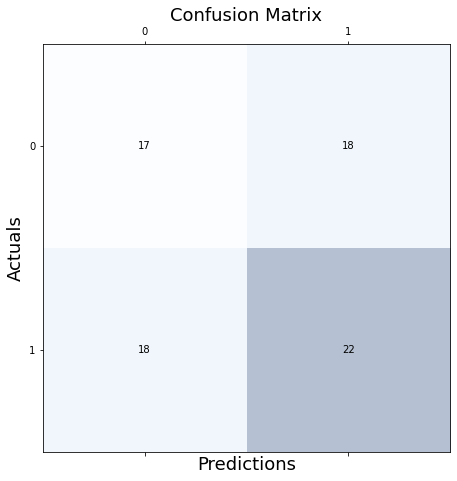

In [109]:
%matplotlib inline

# Confusion Matrix

conf_mat = confusion_matrix(dat_actual, dat_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j],va='center',ha='center')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()